# Competing for Talent: Is Competition in Hiring Linked to Higher Startup Employee Wages and What Other Factors Contribute?

## INTRODUCTION

The study of startups is a compelling research area for those concerned with innovation and markets. Startups have great potential to introduce novel technologies, but proper strategy is critical to achieving the brand recognition and reputation necessary for these impacts (Hashai & Markovich, 2017). Moreover, the positive effects aren’t limited to technology development. Startups can also be a source of attractive jobs by offering interesting positions or a close-knit work environment. The data surrounding startup pay suggests lower wages, but without a clear consensus. First, based on Danish registry data, Sorenson et al. concludes that startup employees earn about 17% less than employees at larger comparable firms over 10 years (Sorenson et al., 2021). Estimates from Germany also support lower salaries when everything else is held constant (Brixy et al., 2006). However, J. Daniel Kim’s work finds a wage premium for venture capital backed firms due to their selection of especially skillful employees (Kim, 2018).


Shifting to wage determination within startups, Li Yang’s research on market competition and employee wage for Chinese companies found a statistically significant positive effect (Yang, 2016). As this work is relatively unique in studying wage determination for all employees rather than founders, it directly motivates my analysis. In this paper, I examine the relationship between an estimator for startup hiring-related competition and wages by merging startup data from 2013 with technology sector salary data from 2016.


## DATA EXPLANATION

I use individual level salary survey responses from Hacker News, combined with entity level startup investment data from Crunchbase. Observations are merged on company name, so startups are grouped with corresponding 2016 salaries of their employees.

The main outcome variable is annual base pay in USD from the salary survey responses.

### Explanatory variables:

**Total startup funding** in USD is examined since it can act as a potential measure of the ability of a startup to pay high salaries. Comparing the impact of the number of competitor employees only for startups with similar funding can better isolate the effect.

Similarly, the **number of funding rounds** indicates the level of funding available, but also reveals how established the startup is. A later stage startup is likely to have received more funding rounds since it has proven some level of reputation and success to investors. As a result, it is another critical control variable.

An employee’s level of experience is known to be correlated with wage. Including this variable clarifies whether the potential difference in wage for startups with a greater prevalence of competitor employees is due to competition pressure directly or different employee selection tied to experience.

The number of employees in the data for each startup provides another potential dimension that can be impacted by the level of competitor employees. Instead of later hiring employees at a higher wage, perhaps startups anticipating facing competition strategically hire more workers ahead of time.

The number of competitors is a metric which estimates hiring competition by counting the number of competitor employees (meaning other workers in the same industry but not the same startup) within a 300 mile radius of each employee. This is a useful measure of hiring competition because firms that hire workers in the same industry and the same location are competitors for labor. As a result, increased competition should theoretically be associated with higher wages.


## DATA CLEANING/LOADING

In [43]:
!pip install -q pandas matplotlib seaborn numpy plotly.express qeds fiona geopandas gensim folium pyLDAvis descartes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate
import plotly.express as px

In [11]:
tech_salaries = pd.read_csv('/Users/annamezhlauk/Desktop/ECO225Project/Data/Tech_salaries.csv')
startups_main = pd.read_csv('/Users/annamezhlauk/Desktop/ECO225Project/Data/Startups/objects.csv', low_memory = False)

In [12]:
# dropping observations with "spam" position names
tech_salaries = tech_salaries.drop([44, 53, 267, 281, 522, 586, 646, 789, 1303, 1422, 1423, 1424, 1555, 1595, 1640, 1642], axis=0)


# dropping observations where compensation isn't in USD
tech_salaries = tech_salaries.drop([1448, 1132, 860, 766, 689, 677, 387, 21], axis=0)

# dropping improbable salaries that could be data entry mistakes
tech_salaries = tech_salaries[(tech_salaries['annual_base_pay'] >= 5000) & (tech_salaries['annual_base_pay'] <= 3000000
                                                                           )].reset_index(drop=True)

In [13]:
startups_main.rename(columns = {"normalized_name": "employer_name"}, inplace = True)
startups_main.rename(columns = {"entity_id": "startup_id"}, inplace = True)

In [14]:
startups_main['startup_id'] = startups_main['startup_id'].astype('Int64')
startups_and_salaries = tech_salaries.merge(startups_main, how="left", on="employer_name")

## VARIABLE CREATION

In [16]:
# creating a column for the number of employees in the data at each startup
startups_and_salaries['num_employees'] = startups_and_salaries.groupby('startup_id')['salary_id'].transform('count')

### Helper functions for variable creation:

In [18]:
def distance_formula(lat1, lon1, lat2, lon2):
    """Return the distance between the points at lat1 lon1 and lat2 lon2 in miles.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # this is the haversine formula (from community.esri.com)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    radius_earth_miles = 3960
    return radius_earth_miles * c


def count_competitor_employees(df, radius):

    df['competitors'] = np.nan

    # this is to make sure employees within the 'other' category aren't counted as competitor employees
    for category in df['job_title_category'].dropna().unique():
        if category == "Other":
            continue

        category_df = df[df['job_title_category'] == category]

        # iterates over each startup & exits the loop early if location data is missing
        for i, row in category_df.iterrows():
            if pd.isna(row['location_latitude']) or pd.isna(row['location_longitude']):
                continue
            
            lat1, lon1 = row['location_latitude'], row['location_longitude']
            competitors = 0

            
            # compares with startups in the same category
            for j, comp_row in category_df.iterrows():
                
                # checking for missing values
                if pd.notna(row['startup_id']) and pd.notna(comp_row['startup_id']) and row['startup_id'] != comp_row['startup_id']:
                    if pd.notna(comp_row['location_latitude']) and pd.notna(comp_row['location_longitude']):
                        lat2, lon2 = comp_row['location_latitude'], comp_row['location_longitude']

                        # adds competitors based on distance
                        if distance_formula(lat1, lon1, lat2, lon2) <= radius:
                            competitors += comp_row['num_employees']

            df.at[row.name, 'competitors'] = competitors

    return df

In [19]:
# using the count_competitor_employees function to add that column
startups_and_salaries = count_competitor_employees(startups_and_salaries, 300)

# group by startup_id and calculate the average salary
avg_salary_by_startup = startups_and_salaries.groupby('startup_id')['annual_base_pay'].transform('mean')

startups_and_salaries['avg_salary_per_startup'] = avg_salary_by_startup

## SUMMARY STATISTICS TABLES

In [45]:

pd.set_option('display.float_format', '{:.2f}'.format)


summary_vars = ['competitors', 'funding_total_usd', 'funding_rounds', 
                'total_experience_years', 'num_employees', 'annual_base_pay']


summary_stats_all = startups_and_salaries[summary_vars].describe().transpose()
summary_stats_ipo = startups_and_salaries[startups_and_salaries['status'] == 'ipo'][summary_vars].describe().transpose()
summary_stats_non_ipo = startups_and_salaries[startups_and_salaries['status'] != 'ipo'][summary_vars].describe().transpose()

summary_stats_all = summary_stats_all.round(2)
summary_stats_ipo = summary_stats_ipo.round(2)
summary_stats_non_ipo = summary_stats_non_ipo.round(2)


summary_stats_all = summary_stats_all[['count', 'mean', 'std', 'min', 'max']]
summary_stats_ipo = summary_stats_ipo[['count', 'mean', 'std', 'min', 'max']]
summary_stats_non_ipo = summary_stats_non_ipo[['count', 'mean', 'std', 'min', 'max']]

table_all = tabulate(summary_stats_all, headers='keys', tablefmt='github', floatfmt=".2f")
table_ipo = tabulate(summary_stats_ipo, headers='keys', tablefmt='github', floatfmt=".2f")
table_non_ipo = tabulate(summary_stats_non_ipo, headers='keys', tablefmt='github', floatfmt=".2f")

print("Table 1: Summary Statistics for All Startups")
print(table_all)
print("\nTable 2: Summary Statistics for IPO Startups")
print(table_ipo)
print("\nTable 3: Summary Statistics for Non-IPO Startups")
print(table_non_ipo)

Table 1: Summary Statistics for All Startups
|                        |   count |        mean |          std |     min |           max |
|------------------------|---------|-------------|--------------|---------|---------------|
| competitors            |  847.00 |      390.57 |       652.32 |    0.00 |       2660.00 |
| funding_total_usd      | 1504.00 | 75103699.74 | 345907021.82 |    0.00 | 2425700000.00 |
| funding_rounds         | 1504.00 |        0.93 |         2.15 |    0.00 |         13.00 |
| total_experience_years | 2078.00 |        6.71 |         5.37 |    0.00 |         40.00 |
| num_employees          | 1504.00 |       19.04 |        23.61 |    1.00 |         62.00 |
| annual_base_pay        | 2130.00 |   116395.53 |    111638.93 | 5160.00 |    2000000.00 |

Table 2: Summary Statistics for IPO Startups
|                        |   count |         mean |          std |     min |           max |
|------------------------|---------|--------------|--------------|---------|----

The annual base pay estimates look very standard. There is a positive skew for base pay (evident from the mean being greater than the median in both tables). Notice, however, that those estimates are higher for IPO startups. They also have more total funding, funding rounds, and competitor employees. The difference in funding is intuitive since IPO startups are likely more established than the entire group, having made it to that stage. An increased number of competitor employees is also not surprising given that a startup may have more employees once it reaches IPO.

From table 1, more than 25% of employees have 0 nearby competitor employees. This will make analyzing a relationship with salary more difficult, as there is less total variation in competitor employees when many values are 0.

## PLOTS, HISTOGRAMS, FIGURES

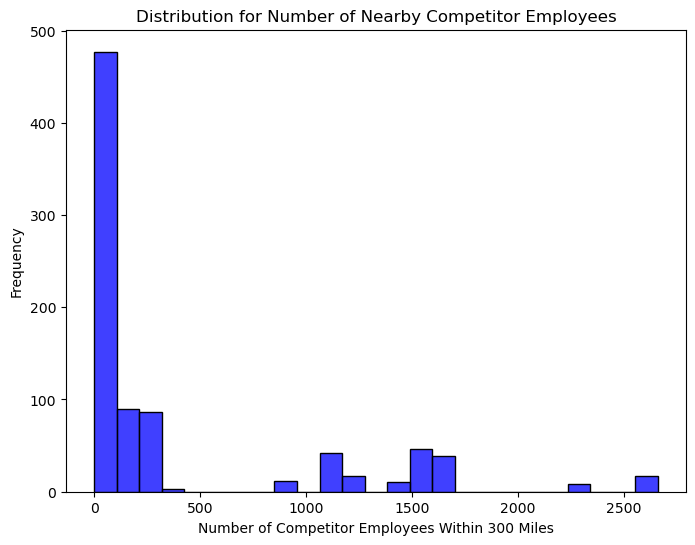

In [24]:
plt.figure(figsize=(8, 6))
sns.histplot(startups_and_salaries['competitors'], bins=25, kde=False, color='blue')

plt.title("Distribution for Number of Nearby Competitor Employees")
plt.xlabel("Number of Competitor Employees Within 300 Miles")
plt.ylabel("Frequency")
plt.show()

From this distribution of competitor employee count, it's immediately clear that a lot of workers do not have many competitor employees near them. There is a significant number who have less than 100. This is a consequence of the small number of observations (< 1000) caused by some rows having either missing location or job category entries. 

There are also clusters around 1300 and 2300 competitor employees due to small samples of nearby firms with many employees being competitors for each other.

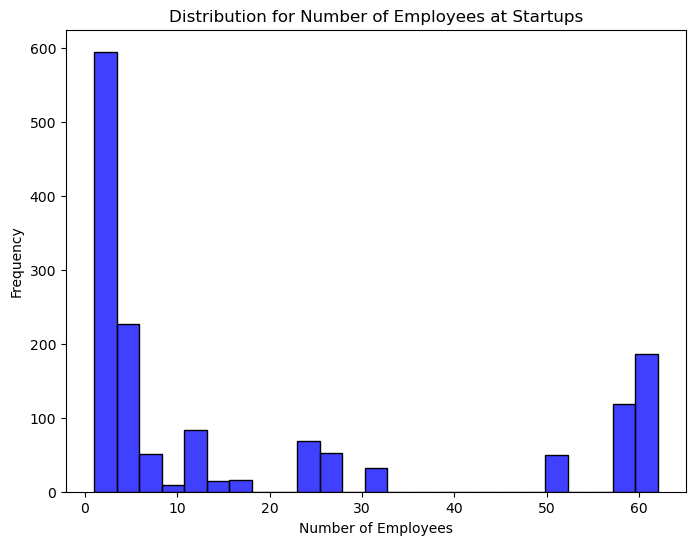

In [26]:
plt.figure(figsize=(8, 6))
sns.histplot(startups_and_salaries['num_employees'].dropna(), bins=25, color='blue')
plt.title("Distribution for Number of Employees at Startups")
plt.xlabel("Number of Employees")
plt.ylabel("Frequency")
plt.show()

Verifying this by directly plotting the distribution of the number of employees at each startup, the assumption proves correct. There is a relatively small number of startups who have roughly 50-60 employees in the data. This is considerably more than average.

Again, we see that many startups have only a few employees within our data.

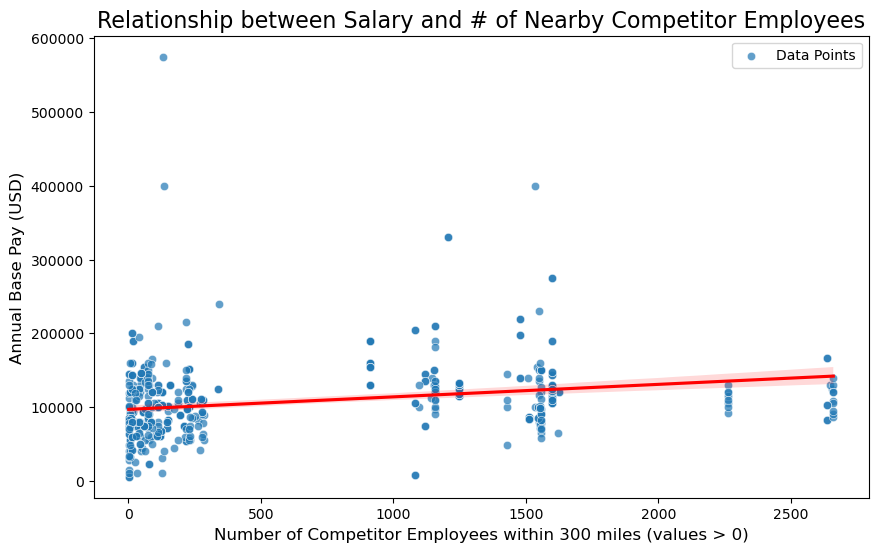

In [28]:
filtered = startups_and_salaries[startups_and_salaries['competitors'] > 0]

plt.figure(figsize=(10, 6))

sns.scatterplot(data=filtered, x='competitors', y='annual_base_pay', alpha=0.7, label="Data Points")

sns.regplot(data=filtered, x='competitors', y='annual_base_pay', scatter=False, color='red', label="Line of Best Fit")

plt.title('Relationship between Salary and # of Nearby Competitor Employees', fontsize=16)
plt.xlabel('Number of Competitor Employees within 300 miles (values > 0)', fontsize=12)
plt.ylabel('Annual Base Pay (USD)', fontsize=12)

plt.show()

Now creating a scatter plot, the same clusters appear, as expected. 

There is a severely weak positive relationship between the number of nearby competitor employees and salary based on the available data. Salary and location changes over time would have more potential to capture the effect. 

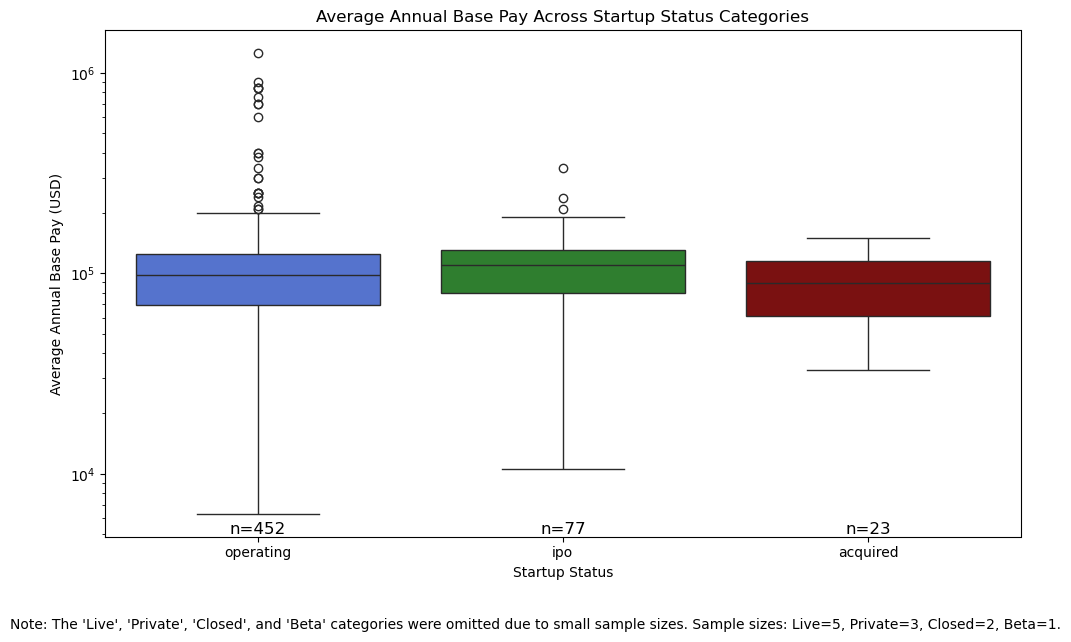

In [30]:
# filtering startup status
filtered = startups_and_salaries[startups_and_salaries['status'].isin(['operating', 'ipo', 'acquired'])]

# calculating avg pay
startup_avg_pay = filtered.groupby(['startup_id', 'status'])['annual_base_pay'].mean().reset_index()


status_counts = startup_avg_pay['status'].value_counts()

# making sample size table
sample_size_table = pd.DataFrame(status_counts).reset_index()
sample_size_table.columns = ['Status', 'Sample Size']


custom_palette = {'operating': 'royalblue', 'ipo': 'forestgreen', 'acquired': 'darkred'}


plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x='status', y='annual_base_pay', data=startup_avg_pay, 
    order=status_counts.index, palette=custom_palette, hue='status'
)
plt.title("Average Annual Base Pay Across Startup Status Categories")
plt.ylabel("Average Annual Base Pay (USD)")
plt.xlabel("Startup Status")
plt.yscale("log")  # log scale for salary distribution

# adding the sample size labels
for i, status in enumerate(status_counts.index):
    count = status_counts[status]
    plt.text(i, ax.get_ylim()[0], f'n={count}', ha='center', va='bottom', fontsize=12, color='black')


plt.figtext(
    0.5, -0.05, 
    "Note: The 'Live', 'Private', 'Closed', and 'Beta' categories were omitted due to small sample sizes. "
    "Sample sizes: Live=5, Private=3, Closed=2, Beta=1.", 
    ha='center', va='center', fontsize=10, color='black'
)

plt.tight_layout()
plt.show()




As the number of nearby competitor employees does not have a strong correlation with salary, we analyze whether startup status matters.

It is unsurprising that the startups at IPO status pay more than those at operating status, given that IPO is a later stage associated with more capital/investment accumulation and resources. There is also a tighter salary range for these startups.

Acquired startups pay the least out of the three groups, although slightly. This result is expected since each case can be different based on the reason for acquisition. Struggling startups are unlikely to pay high wages. When they end up getting acquired, employee wages may remain low. Alternatively, some acquired startups were doing well, but got acquired by large firms due to financial incentives. This situation could lead to lower or higher wages depending on the pay structure of the acquiring firm.

Importantly, the lack of observations for the 4 remaining categories introduces potential for bias in this analysis. We don't have representation from each available group, as we merged with salary data, which is likely to include more entries for startups that are the most established.

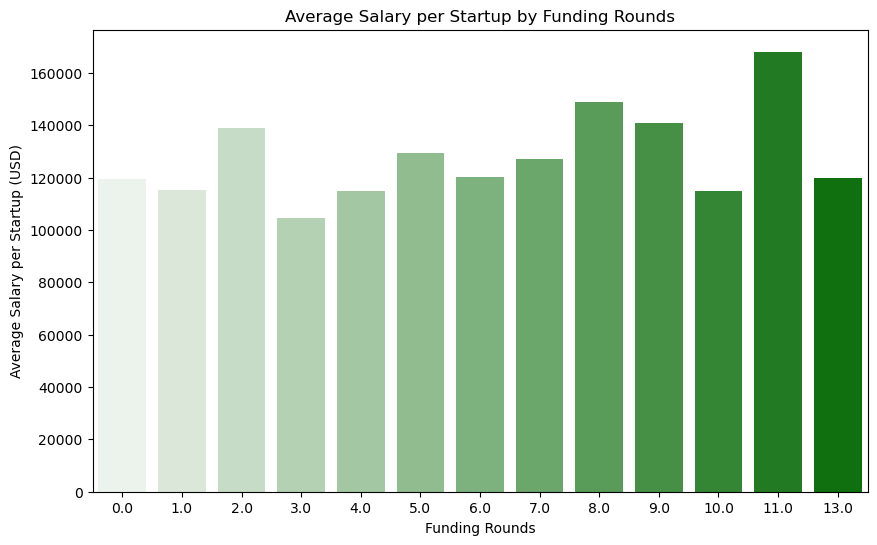

In [32]:
# calculating avg salary by funding round
funding_rounds_avg_salary = startups_and_salaries.groupby('funding_rounds')['avg_salary_per_startup'].mean().reset_index()


green_palette = sns.light_palette("green", n_colors=len(funding_rounds_avg_salary))


plt.figure(figsize=(10, 6))
sns.barplot(x='funding_rounds', y='avg_salary_per_startup', data=funding_rounds_avg_salary, hue='funding_rounds', palette=green_palette,
            legend=False)
plt.title('Average Salary per Startup by Funding Rounds')
plt.xlabel('Funding Rounds')
plt.ylabel('Average Salary per Startup (USD)')
plt.show()


Finding wage differentiation across status groups suggests that some patterns are present in the data, despite our inconclusive results on competitor employees. 

However, after investigating the role of funding rounds in particular, it is clear that the average salary paid is uncorrelated with the number of rounds completed. This suggests that the money raised is being utilized for other purposes. There is no relationship with this factor.

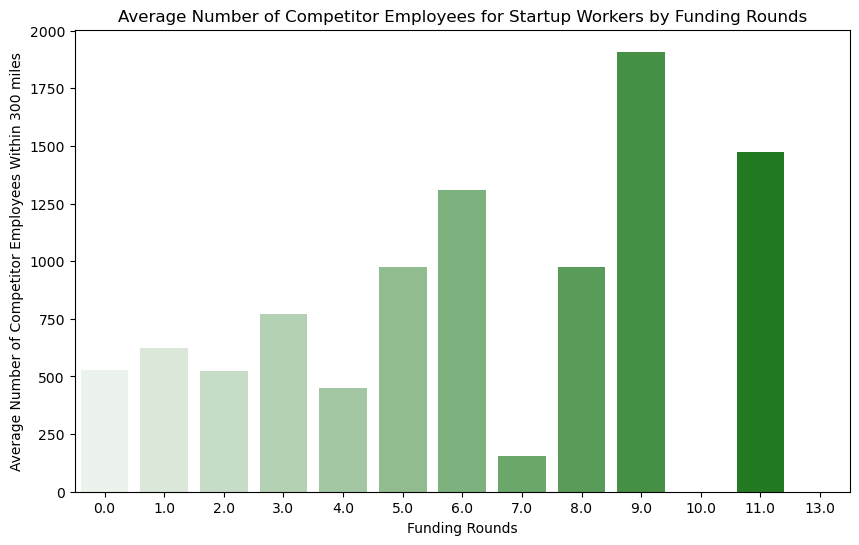

In [34]:
# calculating avg number of competior employees by funding round
funding_rounds_avg_competitors = startups_and_salaries.groupby('funding_rounds')['competitors'].mean().reset_index()


green_palette = sns.light_palette("green", n_colors=len(funding_rounds_avg_competitors))


plt.figure(figsize=(10, 6))
sns.barplot(x='funding_rounds', y='competitors', data=funding_rounds_avg_competitors, hue='funding_rounds', palette=green_palette,
            legend=False)
plt.title('Average Number of Competitor Employees for Startup Workers by Funding Rounds')
plt.xlabel('Funding Rounds')
plt.ylabel('Average Number of Competitor Employees Within 300 miles')
plt.show()


Still, there is a positive relationship between the number of funding rounds completed and the average number of competitor employees for each startup's workers. This is further evidence of several large firms being located near each other. The high bars at completed funding rounds 9 and 11 imply that these firms have accumulated a lot of capital from investors.

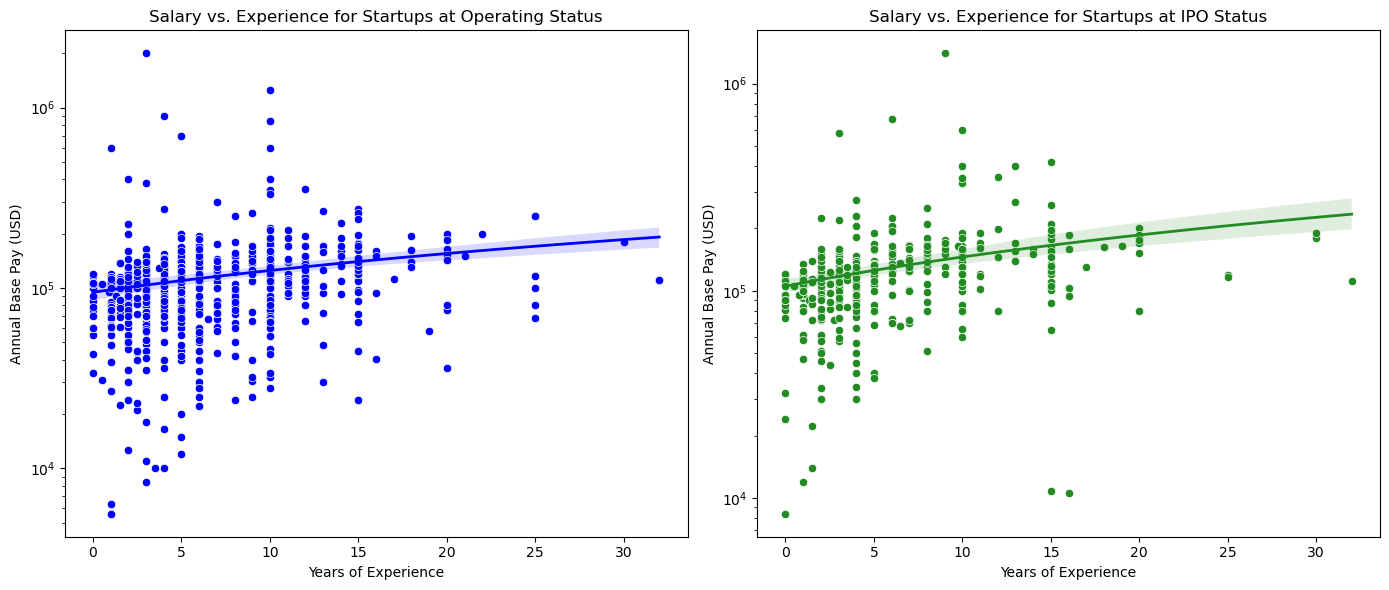

In [41]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.scatterplot(x='total_experience_years', y='annual_base_pay', 
                data=startups_and_salaries[startups_and_salaries['status'] == 'operating'], 
                ax=axes[0], color='blue')
sns.regplot(x='total_experience_years', y='annual_base_pay', 
            data=startups_and_salaries[startups_and_salaries['status'] == 'operating'], 
            ax=axes[0], scatter=False, color='blue', line_kws={'linewidth': 2})
axes[0].set_title('Salary vs. Experience for Startups at Operating Status')
axes[0].set_xlabel('Years of Experience')
axes[0].set_ylabel('Annual Base Pay (USD)')
axes[0].set_yscale('log')  # log scale for salaries


sns.scatterplot(x='total_experience_years', y='annual_base_pay', 
                data=startups_and_salaries[startups_and_salaries['status'] == 'ipo'], 
                ax=axes[1], color='forestgreen')
sns.regplot(x='total_experience_years', y='annual_base_pay', 
            data=startups_and_salaries[startups_and_salaries['status'] == 'ipo'], 
            ax=axes[1], scatter=False, color='forestgreen', line_kws={'linewidth': 2})
axes[1].set_title('Salary vs. Experience for Startups at IPO Status')
axes[1].set_xlabel('Years of Experience')
axes[1].set_ylabel('Annual Base Pay (USD)')
axes[1].set_yscale('log')  # log scale for salaries


plt.tight_layout()
plt.show()

Lastly, we consider Daniel Kim's findings that early stage VC-backed startups hire higher quality employees compared to established firms, giving the appearance of a startup wage premium (Kim, 2018).

If we use years of experience as a measure of quality, we notice that there's a weak positive relationship for both operating and IPO startups. The relationship is likely weak due to limited sample size and not separating observations by industry. 

The effect is the same across both operating and IPO startups, so the likely earlier stage operating firms do not appear to value experience more.

## CONCLUSION

Using 2013 Startup data from Crunchbase and 2016 technology sector salary data from Hacker News, this paper has investigated the relationship between a hiring competition metric and startup employee wages. The results were inconclusive, likely due to limitations caused by sample size and the lack of time series data that could show impacts of hiring competition, startup status, and funding over time. Competitor employee count only had a weak association with salary, and funding level was surprisingly completely uncorrelated. The most strongly supported result is that startups at IPO status paid more, which is expected given that startups are likely more established in their market once they reach IPO. Overall, the ambiguous results in this paper serve as a call to action to investigate factors beyond status, funding, and competition in hiring affecting startup employee wages. 

## REFERENCES

Brixy, U., Kohaut, S., & Schnabel, C. (2006). Do Newly Founded Firms Pay Lower Wages? First Evidence from Germany. Small Business Economics, 29(1-2), 161–171. https://doi.org/10.1007/s11187-006-0015-x

Hashai, N., & Markovich, S. (2017). Market Entry by High Technology Startups: The Effect of Competition Level and Startup Innovativeness. Strategy Science, 2(3), 141–160. https://doi.org/10.1287/stsc.2017.0033

Justinas Cirtautas. (2018). Startup Investments. Kaggle.com. https://www.kaggle.com/datasets/justinas/startup-investments

Kettle, S. (2017, October 5). Distance on a sphere: The Haversine Formula. Esri Community. https://community.esri.com/t5/coordinate-reference-systems-blog/distance-on-a-sphere-the-haversine-formula/ba-p/902128

Kim, J. D. (2018). Is there a startup wage premium? Evidence from MIT graduates. Research Policy, 47(3), 637–649. https://doi.org/10.1016/j.respol.2018.01.010

Sorenson, O., Dahl, M. S., Canales, R., & Burton, M. D. (2021). Do Startup Employees Earn More in the Long Run? Organization Science, 32(3). https://doi.org/10.1287/orsc.2020.1371

The Devastator. (2016). Tech Salaries. Kaggle.com. https://www.kaggle.com/datasets/thedevastator/know-your-worth-tech-salaries-in-2016/data

Yang, L. (2016). Product Market Competition, Competitive Position and Employee Wage. Journal of Human Resource and Sustainability Studies, 04(03), 176–182. https://doi.org/10.4236/jhrss.2016.43019
